# Exploratory Data Analysis

## Music Style Classification

In this notebook I'm analyzing the results of the models classifying mood, style, and genres in the music.

All of the models featured in this notebook were trained on 1280-dim embeddings produced by the [discogs-effnet model](https://essentia.upf.edu/models/music-style-classification/discogs-effnet/discogs-effnet-bs64-1.json)

In [72]:
#Imports
import sqlite3
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from glob import glob
from tqdm import tqdm
import pathlib
import librosa
import taglib
import warnings
warnings.filterwarnings('ignore')
pd.set_option('max_colwidth', 100)

In [2]:
#Imports from project package called project_tools
from project_tools.utils import adapt_array, convert_array, tag_cleaner, json_opener

In [3]:
#Register these functions with sqlite3 so that we I can work with 
sqlite3.register_adapter(np.ndarray, adapt_array)
sqlite3.register_converter("array", convert_array)

In [4]:
#Connect to db
conn = sqlite3.connect("../jaage.db", detect_types= sqlite3.PARSE_DECLTYPES)
cur = conn.cursor()

I'll be analyzing data from the following tables

In [5]:
tables = ['approachability_2c_effnet_discogs_1_activations',
 'danceability_effnet_discogs_1_activations',
 'engagement_2c_effnet_discogs_1_activations',
 'genre_electronic_effnet_discogs_1_activations',
 'mood_acoustic_effnet_discogs_1_activations',
 'mood_aggressive_effnet_discogs_1_activations',
 'mood_happy_effnet_discogs_1_activations',
 'mood_party_effnet_discogs_1_activations',
 'mood_sad_effnet_discogs_1_activations']

Load in tags data 

In [6]:
tags = pd.read_sql_query("SELECT * FROM tags", con = conn).set_index("sid")
tags.head(5)

,length,gain,codec,file_name,bpm,initialkey,title,album,artist,date,genre,label
sid,,,,,,,,,,,,
b806881a54bdbf9dd93a290716adf191,287.393372,-9.895140,pcm_s16le,04 House Of Love_PN.wav,119.0,6A,04 House Of Love_PN,None,None,None,None,None
46e54d2ab920a088b77382e04877141b,311.251892,-11.281836,pcm_s16le,Alex Virgo - Rough N' Ready Edits - 06 A.T.S -...,128.0,1A,A.T.S - Baa Daa Laa (Alex Virgo's Rough n Read...,Rough N' Ready Edits,Alex Virgo,2020,None,None
a204ddef5763df6d8f7677701fe9d96f,415.114746,-9.958479,pcm_s16le,01 Protostar_PN.wav,117.0,5A,Protostar,Planetary Groove,FROM BEYOND,2020,None,None
960097894e83c5810a9c649f17a4e551,321.108765,-12.223524,pcm_s16le,Cristal - Drink My Soul (Running Hot Edit)_PN.wav,0.0,None,None,None,None,None,None,None
a3c1f277aa0110ffc418bf5fa3aa16aa,378.276276,-12.410757,pcm_s16le,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN...,109.0,6A,Maya - Lait De Coco ( Les Yeux Orange Edit)_PN,None,None,2016,None,None


In [7]:
tags.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3337 entries, b806881a54bdbf9dd93a290716adf191 to a917c2e139050eb78d68d963fd4e2da9
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   length      3337 non-null   float64
 1   gain        3337 non-null   float64
 2   codec       3337 non-null   object 
 3   file_name   3337 non-null   object 
 4   bpm         3216 non-null   float64
 5   initialkey  2680 non-null   object 
 6   title       3267 non-null   object 
 7   album       1476 non-null   object 
 8   artist      2360 non-null   object 
 9   date        1037 non-null   object 
 10  genre       287 non-null    object 
 11  label       185 non-null    object 
dtypes: float64(3), object(9)
memory usage: 338.9+ KB


### Ear Test

Similar to the EDA Effnet Genres notebook, I'll be evaluating the models' performance in appraising my song collection based on their criteria. 


I'm especially curious to see the results because mood scores are arguably more useful to me as a DJ. When I curate tracks for a gig, I need to assemble a collection of songs that match the "vibe" of the event. For example I'm not dropping brash techno at a winebar and nor am I spinning somber r'nb at a night club.

Assuming these metrics are fairly workable, I could envision using them as a way to conditionally filter songs for gigs; think writing a query for a night club gig that's like "SELECT songs FROM tbl where dance_score >threshold".


Another thing I'm curious about is that labels such as approachablility, engagement, sadness in a the context of music are much more abstract concepts than say genre. In most cases, a song's genre is undebatable but how do you define how "party" a song is? Even something obvious like "danceability" poses its own unique challenges, how can model get a grasp of how danceable a song is when significantly different genres of music can all be considered highly danceable.

With those and other questions in mind, I'll go through each of the tables and show the top scoring tracks along with links to them so that the reader can conduct their own assessment.

**Approachability**

"Music approachability predicting whether the music is likely to be accessible for the general public (e.g., belonging to common mainstream music genres vs. niche and experimental genres)."

More info ==> https://essentia.upf.edu/models.html#approachability


I'm the first to admit that the music I play is not mainstream — you won't hear any Taylor Swift/Drake mashups at my sets. In fact I've been encouraged by some friends to play more popular music.

With that being said I'm quite eager to know the approachability model's assessment of my collection. What does it mean if a song that is not popular is rated high on the approachability scale? This could potentially be a huge deal because DJs love to play great songs that crowds haven't heard before. So if I have a bunch relatively obscure songs whose sound has massive crossover appeal, I could be onto something here.

In [9]:
table = tables[0]
print(f"Loading {table} data")
approach_df = pd.read_sql_query(f"SELECT * FROM {table}", 
                                con = conn).set_index("sid").applymap(lambda x:x[0])
approach_df = approach_df[~approach_df.index.duplicated(keep='first')]
approach_df.head(5)

Loading approachability_2c_effnet_discogs_1_activations data


,not_approachable,approachable
sid,,
b806881a54bdbf9dd93a290716adf191,"[0.7773523, 0.8477703, 0.74907845, 0.86111253,...","[0.22264773, 0.15222974, 0.25092158, 0.1388874..."
46e54d2ab920a088b77382e04877141b,"[0.9233631, 0.94062567, 0.9361475, 0.9502406, ...","[0.0766369, 0.059374325, 0.06385247, 0.0497593..."
a204ddef5763df6d8f7677701fe9d96f,"[0.31597278, 0.44296739, 0.37413007, 0.3979797...","[0.6840272, 0.5570327, 0.6258699, 0.60202026, ..."
960097894e83c5810a9c649f17a4e551,"[0.4144781, 0.3078609, 0.43320435, 0.2669011, ...","[0.5855219, 0.6921391, 0.5667957, 0.733099, 0...."
a3c1f277aa0110ffc418bf5fa3aa16aa,"[0.828504, 0.7391437, 0.66389257, 0.82320875, ...","[0.17149605, 0.26085627, 0.33610743, 0.1767912..."


In [10]:
approach_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3288 entries, b806881a54bdbf9dd93a290716adf191 to a917c2e139050eb78d68d963fd4e2da9
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   not_approachable  3288 non-null   object
 1   approachable      3288 non-null   object
dtypes: object(2)
memory usage: 77.1+ KB


In [11]:
song1 = approach_df.iloc[0]
song1

not_approachable    [0.7773523, 0.8477703, 0.74907845, 0.86111253,...
approachable        [0.22264773, 0.15222974, 0.25092158, 0.1388874...
Name: b806881a54bdbf9dd93a290716adf191, dtype: object

In [12]:
song1.apply(len)

not_approachable    140
approachable        140
Name: b806881a54bdbf9dd93a290716adf191, dtype: int64

As seen in the EDA Effnet Genres notebook, the data in this and the ensuing tables possess the same structure. Each cell in the pandas dataframe is a N-length array holding the activation scores for the class mentioned in the column name.

In [13]:
def pair_sum(x, col1, col2):
    #Grab the arrays from both columns
    data1 = x[col1]
    data2 = x[col2]
    #Add them together
    summ = data1+data2
    
    #calculate the mean and if the mean is close to 1 then it indicates they basically sum to 1
    return summ.mean()

In [14]:
approach_df.apply(lambda x:pair_sum(x, 'not_approachable', 'approachable'), axis = 1).value_counts()

1.0    3288
dtype: int64

Derive the means and standard deviations of the arrays in each cell

In [15]:
approach_df_mean = approach_df.applymap(lambda x:x.mean())
approach_df_std = approach_df.applymap(lambda x:x.std())

I'm repeating a task I did in the Effnet Genres notebook by comparing the means and standard deviations in order to see how representative a mean is of a whole array.

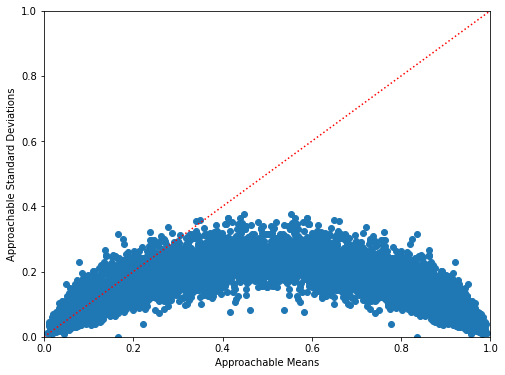

In [16]:
all_means = approach_df_mean.values.flatten()
all_stds = approach_df_std.values.flatten()

plt.figure(figsize=(8, 6))
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.scatter(all_means, all_stds)
plt.plot([0, 1],":", c= "r" )
plt.xlabel("Approachable Means")
plt.ylabel("Approachable Standard Deviations");

For the most part, the means greater than the standard deviations which fills me with more confidence when interpreting analysis made on the means.

**Summary Stats and Distribution**

This function shows a histogram of the activation scores along with the summary statistics.

In [68]:
def dist_viz(col, figsize = (8, 5)):
    plt.figure(figsize = figsize)
    ax = sb.histplot(x= col)
    ax.set_title(f"Distribution of {col.name.title()} Scores", fontsize = 18)
    ax.set_ylabel("Frequency", fontsize = 14)
    ax.set_xlabel(col.name.title() + " scores".title(), fontsize = 14)
    sum_stats = col.describe().round(3).__str__()
    sum_stats = "Summary Stats: \n"+ sum_stats[sum_stats.find("\n"):sum_stats.find("\nName")]
    ax.annotate(sum_stats, (1.1,150), annotation_clip=False, fontsize= 14);

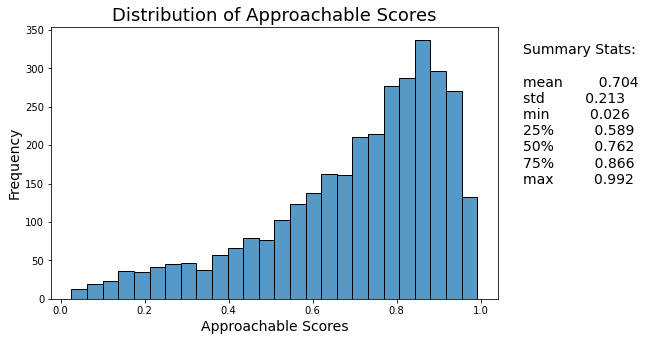

In [69]:
dist_viz(approach_df_mean.approachable)

Given what I wrote earlier, this chart is quite surprising. It indicates that this model highly rates my music collection how accessible it is to the public. 

Select the `approachable` column because we only need one of the two columns.

In [75]:
approach_ser = approach_df_mean.approachable

Create a function that shows the top songs based on scores for a given column

In [81]:
def top_songs(col, n = 10, ascending = False):
    if ascending:
        top_scores = col.nsmallest(n)
    else:
        top_scores = col.nlargest(n)
    return pd.concat([tags, top_scores], 
                     axis = 1).dropna(subset=[col.name])[["title",
                                                            "artist", col.name]].sort_values(by = col.name,
                                                                                        ascending=ascending)

In [82]:
top_approach_songs = top_songs(approach_ser)
top_approach_songs

,title,artist,approachable
sid,,,
bd8fba4e12551113b6bb28e30659cad3,I Love You (Extended),Karriem,0.992329
1b8532b6d23301b8ea16d82d7c33cba3,ouiness_zina_finished!,None,0.988984
c1becbc465751149b42ad8ebbe06d80c,"Şehrazat - Kendim ettim, kendim buldum (disco funk, Turkey 1981)",ultradiskopanorama,0.988932
b6f5a4b06bbd4279f4e8727a137bfe7f,Don't Let Me Down,Marcia Griffiths,0.988707
e68b85b8da0842ca44ad583b4d5cebea,Mioukouna,NST Cophie's,0.988692
6e4b3a2ac6ac5a4eb0acf064b5ed7ac6,Sasà,Oro,0.988083
742d1fc3a38304122239d07244e0106e,Ende Beerabeero Rare Unknown Ethiopian Disco Modern Soul 45-785Pujxp7rU,Habte Awalom,0.987410
0074bca61fc9947f1aae555d7f694139,Tchamy Patterson - First Man for Cry,reclusiv recordings,0.987320
76719cd1329569cac713f5e524c04a72,7404430_Pour moi ça va_(Charles Maurice Version)_PN,None,0.986070


My initial reaction here is skepticism. The songs listed above in the dataframe are certainly not the first songs in my catalog that I would nominate for approachability.

Have a listen and judge for yourself.

1. [I Love You (Extended) - Karriem](https://www.youtube.com/watch?v=kMpdZAuZu7M)

2. [Ouiness - Zina](https://www.youtube.com/watch?v=XIvIjTA1L_E)

3. [Kendim ettim, kendim buldum - Sehrazat](https://www.youtube.com/watch?v=UdICW7YqaoU)

4. [Don't Let Me Down - Marcia Griffiths](https://www.youtube.com/watch?v=dtpDmZpjsJE)

5. [Mioukouna -  N.S.T Cophie's](https://www.youtube.com/watch?v=vnfznqH7vQw)

6. [Sasa - Oro](https://www.youtube.com/watch?v=xC9Itr_jjR4)

7. [Ende Beerabeero - Habte Awalom](https://www.youtube.com/watch?v=785Pujxp7rU)

8. [First Man For Cry - Tchamy Patterson](https://www.youtube.com/watch?v=3fsUubsawsE)

9. [Pour Moi Ca Va (Charles Maurice Version) - France Lise](https://www.youtube.com/watch?v=rLPOJUbWah0)

10. [Sunburn (Al-Tone Edits Vol. 7)	- Unknown Artist](https://www.youtube.com/watch?v=sgiRnolRSYg)

I am perplexed when these songs made the top 10. At least of these tracks I wouldn't play in a typical gig, I'd only play them for a crowd I'm confident will appreciate relative obscure music.

Now let's look at the other side of the spectrum and see how the "unapproachable" songs stack up

In [83]:
least_approachable_songs = top_songs(approach_ser, ascending=True)
least_approachable_songs

,title,artist,approachable
sid,,,
67a5a54a5f62b597509e9d97eae584b3,Extra Vergine,Maus & Stolle,0.025874
a5e390371b3438d58800a9e8fa0332a1,Everybody,DISAIA,0.031497
b6b676e68093434e6c1e0e569b3dfdae,Voodoo Ray (Hey Dan Edit)_PN,A Guy Called Gerald,0.031578
f586f46de0a2df993f5823c2ccad4f96,Maurice - This is Acid (Sportello TB303 Edit),Sportello,0.034087
61f067aa07000144df9044ceedea72da,M4A4 - Raf,None,0.037901
406de514de82d885a907e36adf681cc1,Insomnia 2022 (Extended Mix),"Flo Dosh, Faithless",0.041390
af0865851d40b6d62b5f88a144e7bb5c,603807_Calabria_(Loop)_PN,None,0.043646
14265f14034ad61a32c3bff46ed0e476,9-Vicky_Montefusco_-_Il_Nulla_Cosmico_(Prins_Thomas_remix)_PN,None,0.044638
9f76bf67c3a9d78b28b76020942cb278,See Right Before My Eyes,Maxinne & Hayla,0.045182


1. [Extra Vergine - Maus & Stolle](https://www.youtube.com/watch?v=ykOCriwIatc)

2. [Everybody - DISAIA](https://www.youtube.com/watch?v=Z61TYWLGbck)

3. [Voodoo Ray (Hey Dan Edit) - A Guy Called Gerald](https://www.youtube.com/watch?v=clsB4bISUjc)

4. [This is Acid (Sportello TB303 Edit) - Maurice](https://sportellomusic.bandcamp.com/track/maurice-this-is-acid-sportello-tb303-edit)

5. [M4A4 - Raf](https://www.youtube.com/watch?v=q0sqLhu4vek)

6. [Insomnia 2022 (Extended Mix) - Flo Dosh Faithless](https://www.youtube.com/watch?v=pQgvls0JOXU)

7. [Calabria (Loop) - Rune RK](https://www.youtube.com/watch?v=FbuAinmnkKk)

8. [Il Nulla Cosmico (Prins Thomas Remix) - Vicky Montefusco](https://www.youtube.com/watch?v=pmltulwHFQ8)

9. [See Right Before My Eyes - Maxinne, Hayla](https://www.youtube.com/watch?v=f-gkDiq6zzc)

10. [Imeros - Ryan Murray, Alex Nicco](https://www.youtube.com/watch?v=yBeo1sEkbmI)

There is a stark difference between the bottom and top sets of songs. The bottom ten are or similar to deep house and techno and are the type of songs soundtracking a stoic-faced audience. Whereas the top 10 songs are all funky and percolating buoyant and jovial vibes. 

Comparing the two sets of songs was helpful in advancing my understanding of how this model interprets approachability.

Most importantly I can definitely see myself using this metric in curating a set list.